# Getting Started with Tensorflow

Tensorflow is a framework for defining and running computational graphs. It's primarily used for deep learning although it can also be used for other numerical computing and machine learning tasks.  

In [41]:
import numpy as np
import tensorflow as tf

## Tensorflow Graphs and Sessions

Tensorflow uses computational graphs to run its functions and models. Graphs are defined by their operations and variables.

Sessions are used to run the a graph. They create the connection between the python program and the C++ TF runtime. Setting up the graph, variables and operations can be done outside the session. But, nothing will be run until it's connected to the session and we evaluate the expression that we created.

In [42]:
# set up two variables
x = tf.constant(32, name='x')
y = tf.constant(45, name='y')

# set up some expression to perform on these variables
f = x*y + y*x*y

print(type(f))

<class 'tensorflow.python.framework.ops.Tensor'>


In [43]:
with tf.Session() as sess:
    result = f.eval()
    print('Tensorflow Output:', result)
    
print('Python Output:', 32*45 + 45*32*45)

Tensorflow Output: 66240
Python Output: 66240


### Placeholders

The example that we just set up isn't particularly useful except to add those two specific numbers together. Instead what if we wanted to create a TensorFlow graph that will add any two user defined numbers together? We would want to use use something called a `tf.placeholder` instead of the `tf.variable`. A `tf.placeholder` is an empty bucket used to hold user defined values. Since TensorFlow works by defining computational graphs before running we need to have these placeholders in the graph so that they are accounted for when setting up the graph.

If we set up our `x` and `y` in the following way we will be able to pass values into those buckets when we run the graph. The shape parameter here tells TF to set up buckets of length 1 to hold the scalars that we will pass to the network.

```python
x = tf.placeholder(tf.int32, shape=(1,), name='x_phldr')
y = tf.placeholder(tf.int32, shape=(1,), name='y_phldr')
```

Note, that we need to define the data type and shape of the data that we will pass our graph. If you try to pass a different type or different shape we will get an error.

### Feed Dictionary

To actually pass some values to the placeholders we will use the `feed_dict` parameter when we run the session. We will pass a dictionary with the keys matching the names of our placeholders and the corresponding values as the data to go into each placeholder.

```python
sess.run(z, feed_dict={x:[32], y:[45]})
```

# Exercise: 

Use placeholders to create a system that can add any two numbers. Since we will primarily be doing machine learning with TensorFlow we don't necessarily want the data in our graph at the start. We want to have buckets that we can put data into and get some result. Set up the same system as above except this time using placeholders so that we can pass values into it.

### Answer 

In [44]:
x = tf.placeholder(tf.int32, shape=(1,), name='x_phldr')
y = tf.placeholder(tf.int32, shape=(1,), name='y_phldr')
z = x*y + y*x*y

with tf.Session() as sess:
    result = sess.run(z, feed_dict={x:[32], y:[45]})
    
print(result)

[66240]


# Matrix Operations with TensorFlow

Most machine learning tasks will require us to perform operations on vectors, matrices, and tensors. TensorFlow will obviously have good support for these types of operations (tensor is in the name!). We will create a TensorFlow graph to perform a dot product on a matrix and a vector. One of the most common issues when create deep learning models is that the shapes of the various matrices and tensors are not compatible. This example will get us thinking about those shapes.

We will start out with two place holders here. This time we will define the shapes in an interesting way. Remember performing a dot product with an mxn matrix and a nx1 vector will produce a mx1 vector. It is only necessary for the number of columns in the matrix to match the number of rows in the vector. TensorFlow can make use of this and allow to set the m dimension to an arbitrary value, allow us to pass a matrix with any number of rows into that placeholder. This comes into play when we do mini-batch gradient descent becuase we will be able to change the batch size without having to change the computational graph.

By putting in `None` as an argument in the shape parameter, this allows TensorFlow the freedom to receive a matrix with an arbitrary number of rows for that placeholder. The only shape constraint that we have here is that the second dimension of the matrix must match the first dimension of the vector.

In [45]:
M = tf.placeholder(tf.float32, shape=(None, 10), name='Matrix')
v = tf.placeholder(tf.float32, shape=(10, 1), name='vector')

dot_product = tf.matmul(M, v)

### Exercise

Feed matrices and vectors of various sizes into this dot product by using a TensorFlow `session` and `feed_dict`. Create the matrices and vectors with numpy, using something like `np.random.uniform()` would work well here since it's size parameter will allow you to quickly make new matrices. 

Try to guess what the size of the resulting vector will be. Also make sure to change the sizes of the free dimension in the matrix and see how that changes the output size. You are also  encouraged to purposefully cause errors by mismatching the sizes. These types of errors will crop up from time to time when doing deep learning, so it's good to see what they look like.

### Answer

In [46]:
np_matrix = np.random.uniform(0, 1, size=(4, 10))
np_vector = np.random.uniform(0, 1, size=(10, 1))

with tf.Session() as sess:
    result = sess.run(dot_product, feed_dict={M: np_matrix, 
                                              v: np_vector})

print('Got a vector of shape {}'.format(result.shape))
print(result)

Got a vector of shape (4, 1)
[[2.6219077]
 [1.7841469]
 [2.8662496]
 [1.9408131]]


### Other matrix operations in TensorFlow

Matrix multiplies will be the most common operation when doing deep learning but we will also have to make use of some others. Especiallly if we decide that we need to create a custom loss function to train our neural networks.

```python
tf.mul(x, y) # element-wise multiplication
tf.add(x, y) # add two tensors of the same type
tf.sub(x, y) # subratct two tensors of the same type
tf.pow(x, y) # element-wise power of tensor x to y
tf.exp(x) # take the elementwise exponential of the tensor x, with Euler's number as the base
tf.sqrt(x) # takes the square root of each element in a tensor
tf.div(x, y) # divides two tensors element-wise
```

### Exercise

Create some TensorFlow graphs using some combination of the above operations and run them. Try to work out any shape errors that arise and get one graph running with at least two of these operations. 

# Basic Linear Regression in Tensorflow

In order to make use of TensorFlow's automatic differentiation capabilities we will set up a basic linear regression problem and train it with stochastic gradient descent. This toy example will actually look very similar to setting up a larger neural network and training. In fact we can make the case that linear regression is the simplist type of neural network (a single neuron without an activation function). 

We will use built in optimizers and gradient descent algorithms.


### Import some additional packages and load the data into a usuable form

In [47]:
import pandas as pd
from sklearn.cross_validation import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt

def normalize(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    return (data - mean) / std

In [48]:
house_dat = pd.read_csv('Housing_data/kc_house_data.csv')
house_dat.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


### Import the california housing dataset, view the shapes.

In [49]:

# load the data into numpy arrays
housing_features = house_dat[house_dat.columns.difference(['id', 'price', 'date', 'zipcode'])].values
housing_targets = house_dat.price.values
housing_targets = housing_targets / np.max(housing_targets)

n, f_dim = housing_features.shape

# normalize the features
housing_features= normalize(housing_features)

# add bias
housing_features = np.c_[np.ones((n, 1)), housing_features]

# reshape targets to TF expectation
housing_targets = np.expand_dims(housing_targets, 1)

X_train, X_test, y_train, y_test = train_test_split(housing_features,
                                                    housing_targets,
                                                    test_size=0.1)

print(X_train.shape)
print(y_train.shape)

(19451, 18)
(19451, 1)


## Set up our linear regression model

One great thing about TensorFlow is that if we set up all of our `tf.Variables` and `tf.placeholders` we can then define a bunch of functions that use those. TensorFlow will take care of assembling those functions into a graph when we go to run it. 

We will define our buckets for the user provided values as `tf.placeholders` name `X` and `y`. We will define out weight matrix for the regression with a `tf.Variable` called `W`. A `tf.Variable` is something that can be updated via Stochastic Gradient Descent or other training algorithms. Here we defining the values that the `tf.Variable` will be initialized to at the start of training.

In [50]:
X = tf.placeholder(tf.float32, shape=(None, f_dim+1), name='X')
y = tf.placeholder(tf.float32, shape=(None, 1), name='y')
W = tf.Variable(tf.ones([f_dim+1, 1])) # we add one dimension here so we have a bias

Setting up the actual calculation simply involves taking the matrix multiply of the weight matrix and feature vectors. Doing this will give us a housing price prediction for each example. 

To set up the loss function we take the difference between the predicted value and the true value. Then we square that difference and take the mean over all the examples, this loss is called Mean Squared Error.

We then use the `tf.train.GradientDescentOptimizer` which takes a learning rate as a parameter and tell it to minimize the loss function that we set up. 

This takes care of the necessary set up to allow our regression to train

In [51]:
# set up operation to get the output from the regression, 
# dot product of weight  and features
y_pred = tf.matmul(X, W)

# calculate the mean squared error
error = y_pred - y
loss = tf.reduce_mean(tf.square(error), name='mse')

# use TF's built in autograd features to run gradient descent
train_step = tf.train.GradientDescentOptimizer(learning_rate=0.005).minimize(loss)

When running a TensorFlow graph we need to start a session and use the session to run the graphs that we have built above. Running the loss graph will give us the current `loss` values, running the `training_step` graph will update the weights `W` that we stored in a `tf.Variable`.

A few TensorFlow quirks. When we start a session that contains `tf.Variables` that we want to update we have to initialize those `tf.Variables` in order for them to be updated during the training steps. Additionally, we can save our session states using `tf.train.Saver()`, this will allow us to load up the session later and test our model on the testing data that we previously set aside.

In [52]:
saver = tf.train.Saver()

# after launching a session, run the initializer to initialize all of
# the variables in the graph
init = tf.global_variables_initializer()

EPOCHS = 2000
# save all of the losses
losses = []

with tf.Session() as sess:
    sess.run(init)
    
    for e in range(EPOCHS):
        if e % 100 == 0:
            print("Epoch:", e, 
                  "Current loss:", 
                  sess.run(loss, feed_dict={X: X_train, y: y_train}), 
                  "Test loss:",
                 sess.run(loss, feed_dict={X: X_test, y: y_test}))
            
        sess.run(train_step, feed_dict={X: X_train, y: y_train})
        losses.append(sess.run(loss, feed_dict={X: X_train, y: y_train}))
        
    best_weights = W.eval()
    save_path = saver.save(sess, '/tmp/linear_regression.ckpt')

Epoch: 0 Current loss: 60.145836 Test loss: 65.90065
Epoch: 100 Current loss: 0.93439186 Test loss: 1.016797
Epoch: 200 Current loss: 0.24318606 Test loss: 0.24392053
Epoch: 300 Current loss: 0.08425596 Test loss: 0.08223219
Epoch: 400 Current loss: 0.03517431 Test loss: 0.033933394
Epoch: 500 Current loss: 0.017164774 Test loss: 0.016484886
Epoch: 600 Current loss: 0.009472387 Test loss: 0.009093812
Epoch: 700 Current loss: 0.005725675 Test loss: 0.0055056233
Epoch: 800 Current loss: 0.003710477 Test loss: 0.0035760263
Epoch: 900 Current loss: 0.0025523466 Test loss: 0.0024659673
Epoch: 1000 Current loss: 0.001858741 Test loss: 0.0018004031
Epoch: 1100 Current loss: 0.0014326428 Test loss: 0.0013911442
Epoch: 1200 Current loss: 0.0011665676 Test loss: 0.0011353475
Epoch: 1300 Current loss: 0.0009985287 Test loss: 0.0009735912
Epoch: 1400 Current loss: 0.00089149334 Test loss: 0.0008703359
Epoch: 1500 Current loss: 0.00082283956 Test loss: 0.00080386654
Epoch: 1600 Current loss: 0.0007

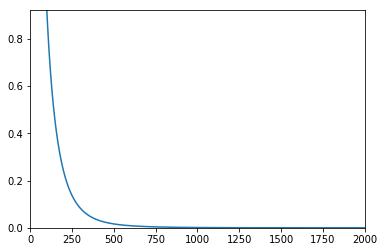

In [53]:
plt.plot(range(len(losses)),np.array(losses))
plt.axis([0,EPOCHS,np.min(losses),np.max(losses[100:])])
plt.show()

# Exercise

### Making predictions on our test data

Now that we have our trained model, we can load it up and make predictions on our test set. Load the model from the stored state, and run the prediction function with a TensorFlow Session on the testing data.

In [54]:
# best weight values are saved in the checkpoint
with tf.Session() as sess:
    saver.restore(sess, '/tmp/linear_regression.ckpt')
    # fill in the rest below

INFO:tensorflow:Restoring parameters from /tmp/linear_regression.ckpt


### Answer

In [55]:
# best weight values are saved in the checkpoint
with tf.Session() as sess:
    saver.restore(sess, '/tmp/linear_regression.ckpt')
    preds = sess.run(y_pred, feed_dict={X: X_test})
    #print(sess.run(loss, feed_dict={X: X_test, y: y_test}))

INFO:tensorflow:Restoring parameters from /tmp/linear_regression.ckpt


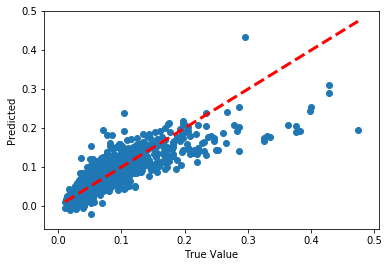

In [56]:
fig, ax = plt.subplots()
ax.scatter(y_test, preds)
ax.plot([y_test.min(), y_test.max()], 
        [y_test.min(), y_test.max()], '--', lw=3, color='r')
ax.set_xlabel('True Value')
ax.set_ylabel('Predicted')
plt.show()